# Visual analysis

In [1]:
import fastf1
import fastf1.plotting
from fastf1.livetiming.data import LiveTimingData

import pandas as pd
import numpy as np
import math

from datetime import datetime, timedelta
from timple.timedelta import strftimedelta
import re

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import FormatStrFormatter

In [2]:
df = pd.read_csv("C:/Users\lmbfr\OneDrive\Documents\Travail ESILV\Cours + Exercices\Semestre 7\Python Data Analysis\F1/allData.csv")

In [3]:
df.head(2)

,number,position,Q1,Q2,Q3,positionText,points,grid,laps,status,...,code,DriverNationality,constructorId,constructorNationality,fastestLapNumber,fastestLapRank,fastestLapAvgSpeed,fastestLapTime,totalTime,TimeInterval
0,44,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,HAM,British,mercedes,German,17.0,1.0,NaN,0 days 00:01:24.026000,NaN,NaN
1,77,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,BOT,Finnish,mercedes,German,9.0,2.0,NaN,0 days 00:01:24.577000,NaN,NaN


### Team colors mapping for plots

In [59]:
#teamColors = ['alfa romeo': '#900000', 'alphatauri': '#2b4562', 'alpine': '#0090ff', 'aston martin': '#006f62', 'ferrari': '#dc0000', 'force_india': '#F596C8', 'haas': '#ffffff', 'mclaren': '#ff8700', 'mercedes': '#00d2be', 'racing_point': '#F596C8', 'red bull': '#0600ef', 'renault': '#FFF500', 'sauber' : '#9B0000', 'toro_rosso': '#0032FF', 'williams': '#005aff']
teamList = df['constructorId'].unique().tolist()
teamList.sort()
teamColors = ['#900000', '#2b4562', '#0090ff', '#006f62', '#dc0000', '#F596C8', '#fdfdfd', '#ff8700', '#00d2be', '#F596C8', '#0600ef', '#FFF500', '#9B0000', '#0032FF', '#005aff']
dictTeamColors = dict(zip(teamList, teamColors))
dictTeamColors

{'alfa': '#900000',
 'alphatauri': '#2b4562',
 'alpine': '#0090ff',
 'aston_martin': '#006f62',
 'ferrari': '#dc0000',
 'force_india': '#F596C8',
 'haas': '#fdfdfd',
 'mclaren': '#ff8700',
 'mercedes': '#00d2be',
 'racing_point': '#F596C8',
 'red_bull': '#0600ef',
 'renault': '#FFF500',
 'sauber': '#9B0000',
 'toro_rosso': '#0032FF',
 'williams': '#005aff'}

### Session retrieval with regex help

In [5]:
#Checks first if number in [1,2,3] exists (--> Practice x), then searches for a "q" (--> Qualification)
#If didn't find any of these conditions (--> Race)
def RetrieveSession(year, gpNumber, sessionName):
    sessionFound = False
    
    digits = re.findall(r'\d', sessionName)
    if (len(digits) > 0):
        if (digits[0] in ['1', '2', '3']):
            sessionName = "Practice " + digits[0]
            sessionFound = True
        
    if (sessionFound == False):
        if (bool(re.search(r'q', sessionName, flags=re.IGNORECASE))):
            sessionName = "Qualifying"
        else:
            sessionName = "Race"
    
    sessionSelected = df[(df["year"] == year) & (df["gpNumber"] == gpNumber) & (df["sessionName"] == sessionName)]
    return sessionSelected

### Formatting methods

In [6]:
def StringToTimeDelta(time):
    try:
        if (time[0] == "+"):
            time = time[1:]
        digits = re.findall(r"\d+", time)
        if (len(digits) == 2):
            delta = timedelta(seconds = int(digits[0]), microseconds = int(digits[1]) * 1000)
        else:
            delta = timedelta(minutes = int(digits[0]), seconds = int(digits[1]), microseconds = int(digits[2]) * 1000)
        return delta
    except:
        return time

In [7]:
def FakeTimeDeltaToTimeDelta(time):
    try:
        min = time[10:12]
        sec = time[13:15]
        thousandth = time[16:19]
        delta = timedelta(minutes = int(min), seconds = int(sec), microseconds = int(thousandth) * 1000)
        return delta
    except:
        return time

In [8]:
def FirstListElement(l):
    if len(l) > 0:
        return int(l[0])
    else:
        return np.NaN

In [9]:
def RaceTimeInterval(x):
    seconds = int(re.findall(r'\d+', str(x))[0])
    if (seconds >= 60):
        seconds = f"{seconds//60}m{seconds%60}"
    return seconds

## Session Ranking Display (Practice, Quali, Race)

In [10]:
def RankingDisplay(session, Number = None):
    
    fig, ax = plt.subplots()
    title = ""
    
    team_colors = list()
    for index, row in session.iterrows():
        color = dictTeamColors[row["constructorId"]]
        team_colors.append(color)
        
    if (bool(re.search(r'practice', session["sessionName"].iloc[0], flags=re.IGNORECASE))):
        session['fastestLapTime'] = session['fastestLapTime'].apply(FakeTimeDeltaToTimeDelta)
        session['DeltaP'] = session['fastestLapTime'] - session['fastestLapTime'].min()
        
        ax.barh(session.index, session['DeltaP'],
                color = team_colors, edgecolor='grey')
        
        ax.set_xticklabels([f"+{x}s" for x in ax.get_xticks()[:-1] / 1000000000])

        ax.set_yticks(session.index)
        ax.set_yticklabels(session['code'])

        ax.invert_yaxis()

        ax.set_axisbelow(True)
        ax.xaxis.grid(True, which='major', linestyle='--', color='black', zorder=-1000)

        fastest = session[session["DeltaP"] == timedelta(0)]
        title = session["gpName"].iloc[0] + " " + str(session["year"].iloc[0]) + " " + str(session["sessionName"].iloc[0])
        title += "\nFastest Lap: " + strftimedelta(fastest["fastestLapTime"].iloc[0], '%m:%s.%ms') + " by " + fastest["driverId"].iloc[0].capitalize()
        
        
    
    elif (session["sessionName"].iloc[0] == "Qualifying"):
        session['Q1'] = session['Q1'].apply(StringToTimeDelta)
        session['Q2'] = session['Q2'].apply(StringToTimeDelta)
        session['Q3'] = session['Q3'].apply(StringToTimeDelta)

        session['DeltaQ1'] = session['Q1'] - session['Q1'].min()
        session['DeltaQ2'] = session['Q2'] - session['Q2'].min()
        session['DeltaQ3'] = session['Q3'] - session['Q3'].min()
        
        session = session[session[f'Q{Number}'].notnull()]
    
        ax.barh(session.index, session[f'DeltaQ{Number}'],
                color = team_colors, edgecolor='grey')
        
        #maxDelta = math.ceil(session[f"DeltaQ{Number}"].max().seconds + (session[f"DeltaQ{Number}"].max().microseconds / 1000000))
        #ticksNumber = len(ax.get_xticklabels()) - 1
        #ax.set_xticklabels([f"+{x}s" for x in np.arange(0,maxDelta,round(maxDelta/ticksNumber, 2))])
        
        ax.set_xticklabels([f"+{x}s" for x in ax.get_xticks()[:-1] / 1000000000])

        ax.set_ylabel('Sunday Grid Order', fontsize = 10)
        ax.yaxis.set_label_coords(-0.042, .5)
        ax.set_yticks(session.index)
        ax.set_yticklabels(session['code'])

        ax.invert_yaxis()

        ax.set_axisbelow(True)
        ax.xaxis.grid(True, which='major', linestyle='--', color='black', zorder=-1000)

        fastest = session[session[f"DeltaQ{Number}"] == timedelta(0)]
        title = session["gpName"].iloc[0] + " " + str(session["year"].iloc[0]) + f" Qualifying {Number}"
        title += "\nFastest Lap: " + strftimedelta(fastest[f"Q{Number}"].iloc[0], '%m:%s.%ms') + " by " + fastest["driverId"].iloc[0].capitalize()
        
        if (Number in [1,2]):
            for tick in plt.gca().get_yticklabels()[-5:]:
                tick.set_color('red')
    
    else:
        finishTime = session["TimeInterval"].iloc[0]
        session["TimeInterval"].iloc[0] = '+0.0'
        session["TimeInterval"] = session["TimeInterval"].apply(StringToTimeDelta)

        session["LapsBack"] = session["status"].str.findall(r'\d').apply(FirstListElement)

        session["TimeBack"] = session["LapsBack"]*session["fastestLapTime"].apply(StringToTimeDelta).max()
        session["TimeInterval"] = session["TimeBack"].fillna(session["TimeInterval"])
        
        session.replace({pd.NaT: np.NaN}, inplace = True)
        
        sessionR = session[session["TimeInterval"].notnull()]
        sessionR["TimeInterval"] = pd.to_timedelta(sessionR["TimeInterval"])
        
        hbars = ax.barh(sessionR.index, sessionR["TimeInterval"],
                color = team_colors, edgecolor='grey')
        
        ax.set_xticklabels([f"+{RaceTimeInterval(x)}s" for x in ax.get_xticks()[:-1] / 1000000000])
        
        ax.set_yticks(sessionR.index)
        ax.set_yticklabels(sessionR['code'])

        ax.invert_yaxis()

        ax.set_axisbelow(True)
        ax.xaxis.grid(True, which='major', linestyle='--', color='black', zorder=-1000)
        
        title = sessionR["gpName"].iloc[0] + " " + str(sessionR["year"].iloc[0]) + " " + str(sessionR["sessionName"].iloc[0])
        title += "\nFastest : " + finishTime + " - " + sessionR["driverId"].iloc[0].capitalize()
        
    plt.rcParams["figure.figsize"] = (20,10)
    #plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 12)

    plt.suptitle(title, y = 0.95, fontsize=16)
    
    plt.show()
    
    #Extra race information
    if (session["sessionName"].iloc[0] == "Race"):
        print("Retirements :\n")
        for index, row in session[session["TimeInterval"].isna()].iterrows():
            print(row['code'], "---> DNF /", row['status'])
       
    

### Plotting Examples

<ipython-input-10-f62c48160bbe>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session['fastestLapTime'] = session['fastestLapTime'].apply(FakeTimeDeltaToTimeDelta)
<ipython-input-10-f62c48160bbe>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session['DeltaP'] = session['fastestLapTime'] - session['fastestLapTime'].min()
<ipython-input-10-f62c48160bbe>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"+{x}s" for x in ax.get_xticks()[:-1] / 10000000

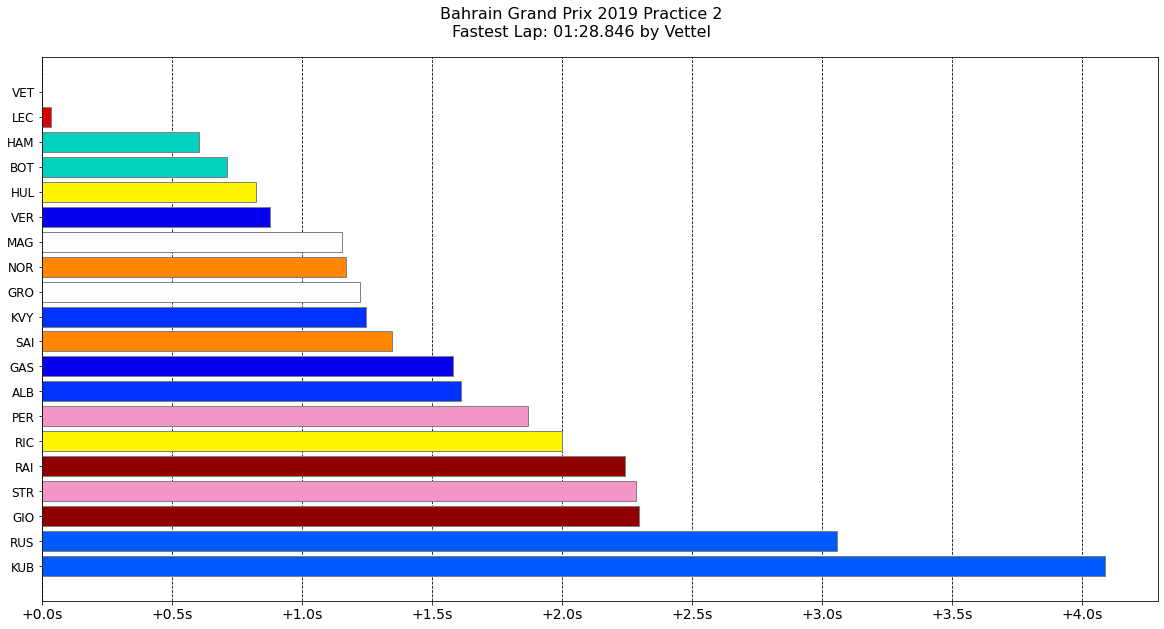

In [257]:
session = RetrieveSession(2019, 2, 'P2')
RankingDisplay(session)

<ipython-input-10-f62c48160bbe>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session['Q1'] = session['Q1'].apply(StringToTimeDelta)
<ipython-input-10-f62c48160bbe>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session['Q2'] = session['Q2'].apply(StringToTimeDelta)
<ipython-input-10-f62c48160bbe>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

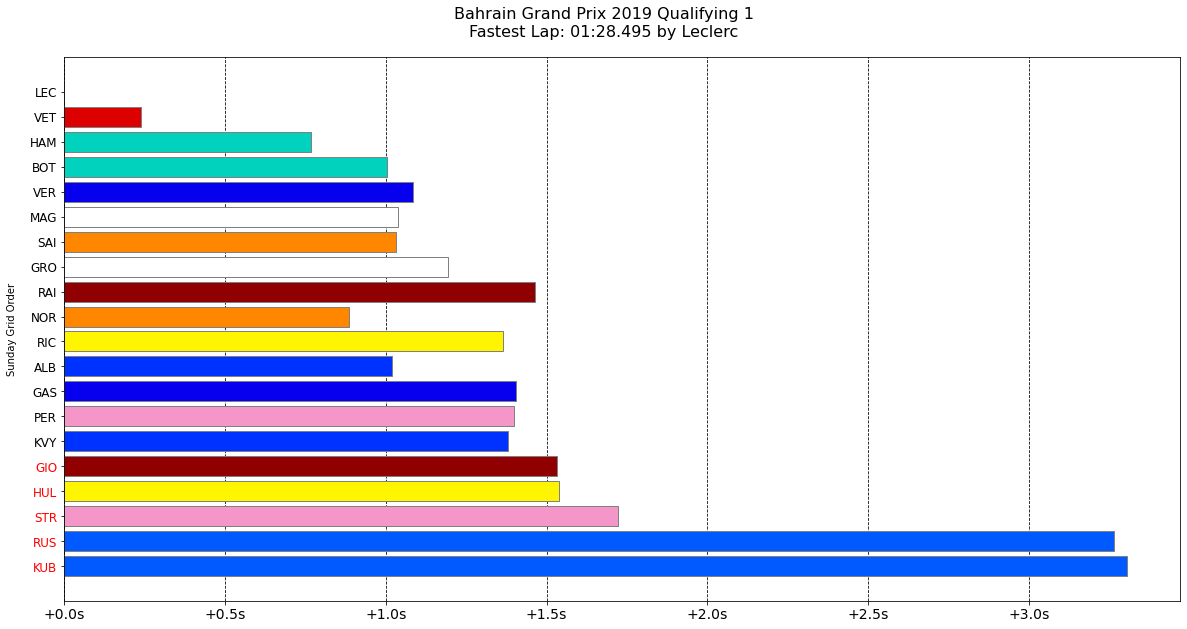

In [12]:
session = RetrieveSession(2019, 2, 'Q')
RankingDisplay(session, 1)

C:\Users\lmbfr\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\lmbfr\anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
<ipython-input-10-f62c48160bbe>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

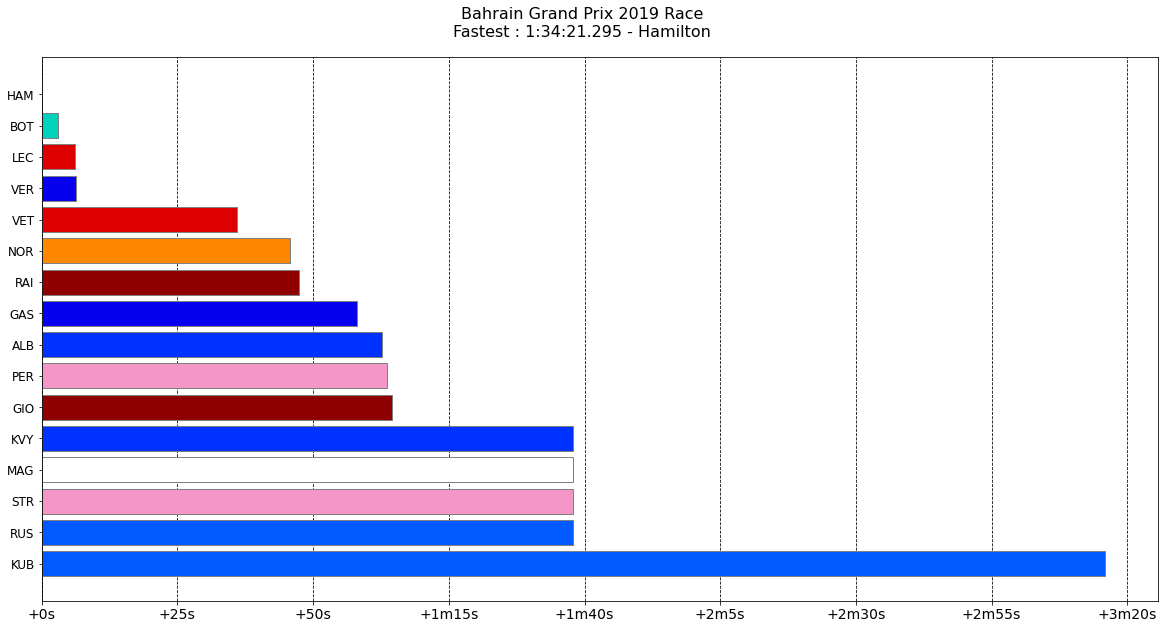

Retirements :

HUL ---> DNF / Engine
RIC ---> DNF / Out of fuel
SAI ---> DNF / Collision damage
GRO ---> DNF / Retired


In [13]:
session = RetrieveSession(2019, 2, 'R')
RankingDisplay(session)

## Drivers/Constructors Performances

In [14]:
races = df[df["sessionName"] == "Race"]

In [15]:
races.head(20)

,number,position,Q1,Q2,Q3,positionText,points,grid,laps,status,...,code,DriverNationality,constructorId,constructorNationality,fastestLapNumber,fastestLapRank,fastestLapAvgSpeed,fastestLapTime,totalTime,TimeInterval
60,5,1,NaN,NaN,NaN,1,25.0,3.0,58.0,Finished,...,VET,German,ferrari,Italian,53.0,4.0,220.782,1:26.469,5373283.0,1:29:33.283
61,44,2,NaN,NaN,NaN,2,18.0,1.0,58.0,Finished,...,HAM,British,mercedes,German,50.0,3.0,220.845,1:26.444,5378319.0,+5.036
62,7,3,NaN,NaN,NaN,3,15.0,2.0,58.0,Finished,...,RAI,Finnish,ferrari,Italian,57.0,2.0,221.027,1:26.373,5379592.0,+6.309
63,3,4,NaN,NaN,NaN,4,12.0,8.0,58.0,Finished,...,RIC,Australian,red_bull,Austrian,54.0,1.0,222.128,1:25.945,5380352.0,+7.069
64,14,5,NaN,NaN,NaN,5,10.0,10.0,58.0,Finished,...,ALO,Spanish,mclaren,British,57.0,7.0,219.489,1:26.978,5401169.0,+27.886
65,33,6,NaN,NaN,NaN,6,8.0,4.0,58.0,Finished,...,VER,Dutch,red_bull,Austrian,54.0,5.0,219.737,1:26.880,5402228.0,+28.945
66,27,7,NaN,NaN,NaN,7,6.0,7.0,58.0,Finished,...,HUL,German,renault,French,57.0,9.0,219.230,1:27.081,5405954.0,+32.671
67,77,8,NaN,NaN,NaN,8,4.0,15.0,58.0,Finished,...,BOT,Finnish,mercedes,German,54.0,8.0,219.386,1:27.019,5407622.0,+34.339
68,2,9,NaN,NaN,NaN,9,2.0,11.0,58.0,Finished,...,VAN,Belgian,mclaren,British,57.0,6.0,219.540,1:26.958,5408204.0,+34.921
69,55,10,NaN,NaN,NaN,10,1.0,9.0,58.0,Finished,...,SAI,Spanish,renault,French,51.0,12.0,217.079,1:27.944,5419005.0,+45.722


### Ranking for a given season

In [247]:
def SeasonRankings(year, constructors):
    
    fig, ax = plt.subplots()
    
    team_colors = list()
    team_colors2 = list()
    
    if (constructors):
        standings = pd.DataFrame(races[races["year"] == year].groupby('constructorId')['points'].sum().sort_values(ascending = False))

        for index, row in standings.iterrows():
                color = dictTeamColors[index]
                team_colors.append(color)
    else:
        driversPoints = pd.DataFrame(races[races["year"] == year].groupby(['code', 'constructorId'])['points'].sum().sort_values(ascending = False))
        driversPoints = driversPoints.reset_index()        
        duplicateDrivers = driversPoints[driversPoints.duplicated(['code'])]
        duplicateDrivers = duplicateDrivers.rename({'constructorId': 'constructorId2', 'points': 'points2'}, axis='columns')
        driversPoints = driversPoints[~driversPoints.isin(duplicateDrivers.copy())].dropna()
        standings = pd.merge(driversPoints.copy(), duplicateDrivers.copy(), on = 'code', how = 'left')
        standings["points2"].replace({np.NaN: 0}, inplace = True)
        standings["constructorId2"].replace({np.NaN: 'empty'}, inplace = True)
        standings['constructorId2'] = np.where(standings['constructorId2'] == 'empty', standings['constructorId'], standings['constructorId2'])
        standings['totalPoints'] = standings['points'] + standings['points2']
        standings = standings.sort_values(['totalPoints'], ascending = False)
        
        
        for index, row in standings.iterrows():
                color = dictTeamColors[row["constructorId"]]
                team_colors.append(color)
                
        for index, row in standings.iterrows():
                color = dictTeamColors[row["constructorId2"]]
                team_colors2.append(color) 
    
    
    indices = np.arange(standings.shape[0])
    total = None
    
    if (constructors):
        plt.bar(indices, standings['points'], width = 0.3, edgecolor='grey', color = team_colors)
        plt.xticks(ticks = indices, labels = standings.index)
        total = standings['points']
    else:
        plt.bar(indices, standings['totalPoints'], width = 0.4, edgecolor='grey', color = team_colors)
        plt.bar(indices, standings['points2'], bottom = standings['points'], width = 0.4, edgecolor='grey', color = team_colors2)
        plt.xticks(ticks = indices, labels = standings["code"])
        total = standings['totalPoints']
    
    n = 1
    for p in ax.patches[1:standings.shape[0]]:
        ax.annotate(s = total.iloc[n],
            xy=(p.get_x()+p.get_width()/2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points')
        n += 1

            
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 12)
    
    title = f"Season {year}\n"
    if (constructors):
        title += f'Constructors Standings - Champions : {standings.index[0].capitalize()} with {standings["points"].iloc[0]} Points'
    else:
        title += f'Drivers Standings - Champion : {standings["code"].iloc[0]} with {standings["totalPoints"].iloc[0]} Points'
    plt.suptitle(title, y = 0.95, fontsize=16)
    plt.show()

#### SeasonRankings Examples

<ipython-input-247-4fafa23c2e66>:52: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.annotate(s = total.iloc[n],


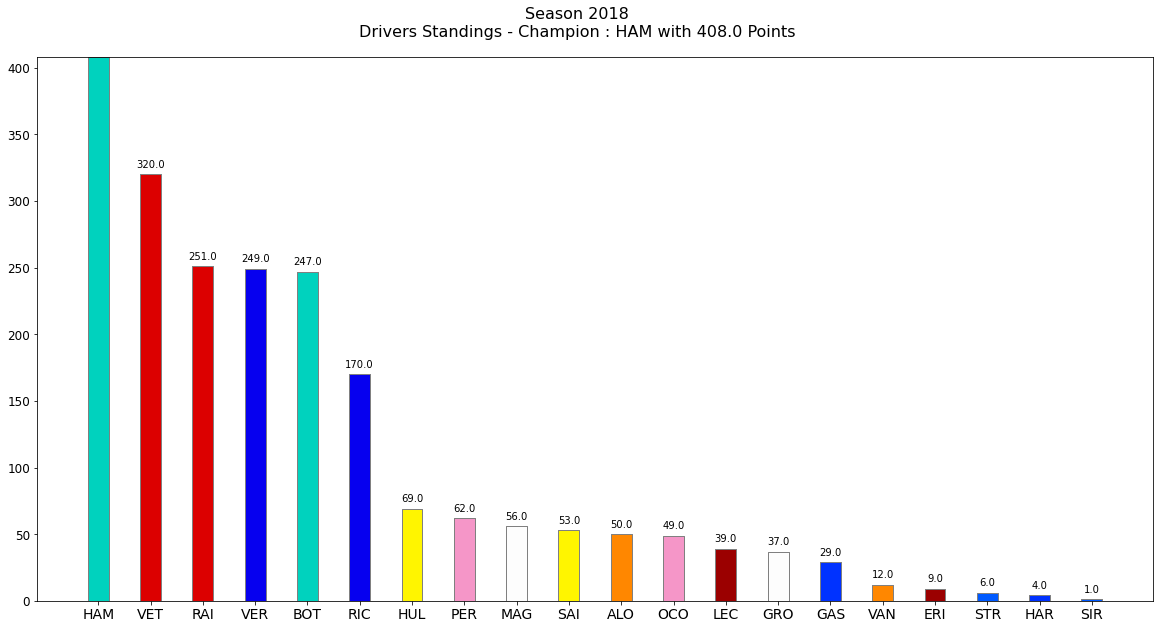

In [250]:
SeasonRankings(2018, False)

<ipython-input-247-4fafa23c2e66>:52: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.annotate(s = total.iloc[n],


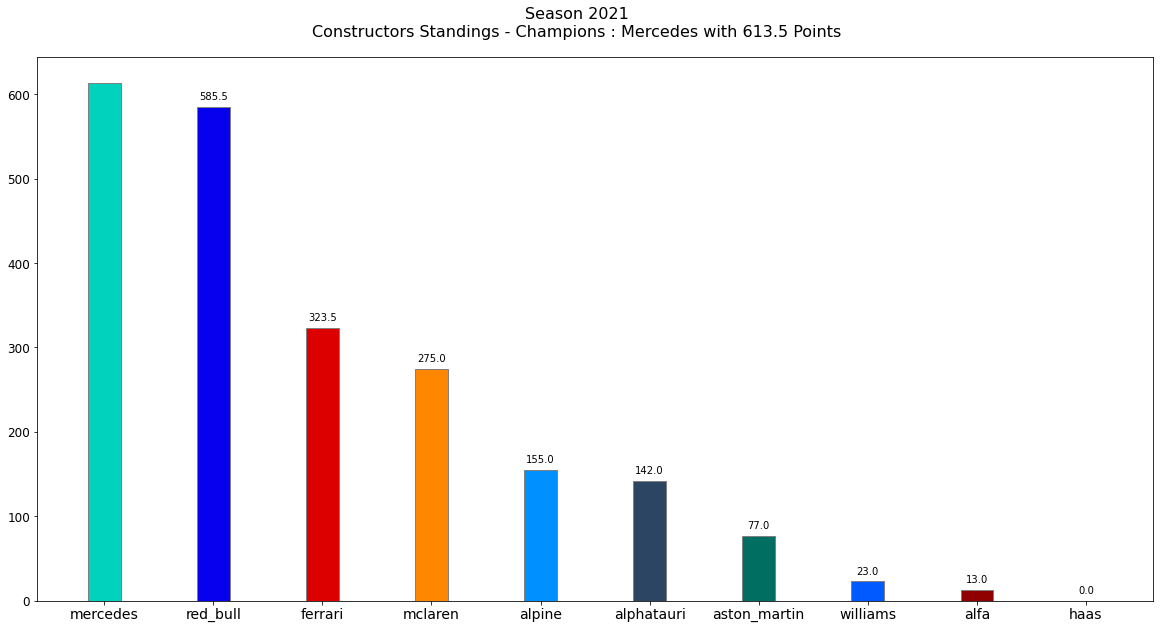

In [251]:
SeasonRankings(2021, True)

### Relation between Qualifying and Race Result for a given season

In [254]:
def QualiRaceRelation(year, DNF):
    if (DNF):
        QRrelation = races[(races["year"] == year) & (races['positionText'] != 'R')].groupby('code')[['grid', 'position']].mean()
    else:
        QRrelation = races[races["year"] == year].groupby('code')[['grid', 'position']].mean()
    QRrelation = QRrelation.sort_values(['grid'])
    QRrelation["racecraftEdge"] = QRrelation["grid"] - QRrelation["position"]
    
    indices = np.arange(QRrelation.shape[0])

    width = 0.30

    plt.bar(indices, QRrelation['grid'], width = width)

    plt.bar(indices + width, QRrelation['position'], width = width)

    plt.xticks(ticks = indices, labels = QRrelation.index)

    plt.gca().legend(('grid position','race result'), fontsize = 12)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 12)
    
    title = f"Grid position/Race result\n{year} F1 season"
    if (DNF):
        title += " excluding weekends where DNFs occurred for drivers"
    plt.suptitle(title, y = 0.95, fontsize=16)
    plt.show()

#### QualiRaceRelation Examples

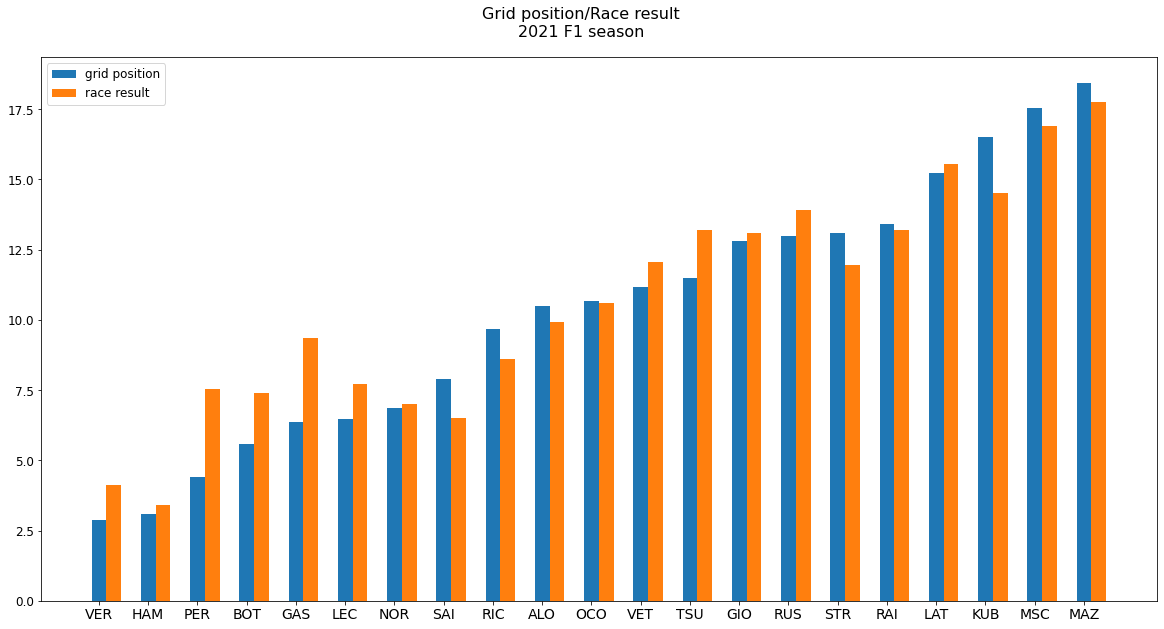

In [255]:
#2nd arg is True if you want to exclude own drivers DNFs from the race result statistic
QualiRaceRelation(2021, False)

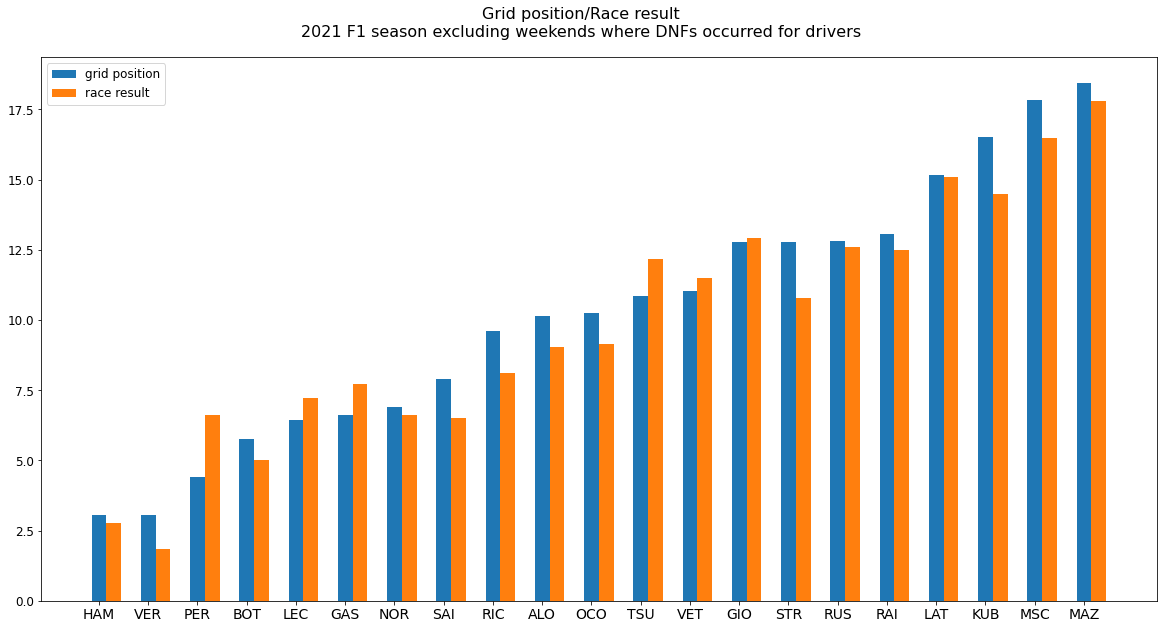

In [256]:
QualiRaceRelation(2021, True)